In [219]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
import sys
import string
import requests
from datetime import datetime, timedelta
import time

Baksetball Reference is accessed through this url: http://www.basketball-reference.com


### Basic player information

By adding /players/'letter', we can view basic info for all active/retired NBA & ABA players with last names starting with that letter. For example, https://www.basketball-reference.com/players/a/ would give the following information for each player with last name starting with 'A':
- From: int variable, career start year
- To: int variable, career end year
- Pos: string variable, basketball position abbreviation
- Ht: string variable, height in feet-inches
- Wt: string variable, weight in pounds
- Brith Date: string variable
- Colleges: string variable, blank if international or did not play in college

In [59]:
def player_info():
    
    players = []
    player_base_url = 'http://www.basketball-reference.com/players/'

    for letter in string.ascii_lowercase: # get player tables from alphabetical list pages
        page_request = requests.get(player_base_url + letter)
        soup = BeautifulSoup(page_request.text,"lxml")
        table = soup.find('table') # find table in soup

        if table:
            table_body = table.find('tbody')
            for row in table_body.findAll('tr'):  # loop over list of players in the table
                player_url = row.find('a') 
                player_pages = player_url['href']  # player page url
                player_names = player_url.text  #p player name

                # get additional player info from table
                cells = row.findAll('td')
                active_from = int(cells[0].text) # 'From' column
                active_to = int(cells[1].text) # 'To' column
                position = cells[2].text # 'Pos' column
                height = cells[3].text # 'Ht' column (feet-inches)
                weight = cells[4].text # 'Wt' column (lbs)
                birth_date = cells[5].text # 'Birth Date' column
                college = cells[6].text # 'Colleges' column (blank is either no college or intl)

                # create entry
                player_entry = {'url': player_pages,
                                'name': player_names,
                                'active_from': active_from,
                                'active_to': active_to,
                                'position': position,
                                'college': college,
                                'height': height,
                                'weight': weight,
                                'birth_date': birth_date}

                # append player dictionary
                players.append(player_entry)
                
    return pd.DataFrame(players)

In [60]:
players_general_df = player_info() # call function that scrapes general info

# convert height to inches
height_inches = players_general_df['height'].str.split('-',expand=True)
players_general_df['height_inches'] = 12.0*pd.to_numeric(height_inches[0], errors='coerce')+pd.to_numeric(height_inches[1], errors='coerce')

# convert birth_date to datetime
players_general_df['birth_date'] = pd.to_datetime(players_general_df['birth_date'])

players_general_df.head(10) # preview

,active_from,active_to,birth_date,college,height,name,position,url,weight,height_inches
0,1991,1995,1968-06-24,Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240,82.0
1,1969,1978,1946-04-07,Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235,81.0
2,1970,1989,1947-04-16,"University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225,86.0
3,1991,2001,1969-03-09,Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162,73.0
4,1998,2003,1974-11-03,"University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223,78.0
5,1997,2008,1976-12-11,University of California,6-9,Shareef Abdur-Rahim,F,/players/a/abdursh01.html,225,81.0
6,1977,1981,1954-05-06,Indiana University,6-7,Tom Abernethy,F,/players/a/abernto01.html,220,79.0
7,1957,1957,1932-07-27,Western Kentucky University,6-3,Forest Able,G,/players/a/ablefo01.html,180,75.0
8,1947,1948,1919-02-09,Salem International University,6-3,John Abramovic,F,/players/a/abramjo01.html,195,75.0
9,2017,2018,1993-08-01,,6-6,Alex Abrines,G-F,/players/a/abrinal01.html,190,78.0


In [96]:
# save in csv format
players_general_df.to_csv('Tables/players_general_df.csv', index=False)

### Detailed player information

The url of each player follows the below format:

* /players/(first letter of the last name)/(first 5 letters of last name)(first 2 letters of first name)(01 unless there's another player that fits the prior name setup, else it's 02, 03, etc).html *

Example, the end of the url for John Wall is https://www.basketball-reference.com/players/w/walljo01.html

Each player's url includes much more information (season, awards, salary, etc.), but we will focus on a couple of statistics, such as career averages.

In [5]:
players_general_df = pd.read_csv('Tables/players_general_df.csv')

In [86]:
def player_detail_info(url):
    '''
    scrape player's personal page. Input is players url (without  www.basketball-reference.com)
    '''
    # we do not need to parse the whole page since the information we are interested in is only a small part
    personal = SoupStrainer('p')
    page_request = requests.get('http://www.basketball-reference.com' + url)
    soup = BeautifulSoup(page_request.text,"lxml",parse_only=personal) # parse only part we are interested in
    p = soup.findAll('p') 

    # initialize some values in case they are unavailable
    shooting_hand = None
    high_school = None
    draft = None
    ppg = None
    trb = None
    ast = None

    # loop over personal info to get certain information
    for prow in p:
        # look for shoots field
        if 'Shoots:' in prow.text:
            s = prow.text.replace('\n','').split(u'\u25aa') # clean text
            if len(s)>1:
                shoots = s[1].split(':')[1].lstrip().rstrip()
        elif 'High School:' in prow.text:
            s = prow.text.replace('\n','').split(':') 
            if len(s)>1:
                high_school = s[1].lstrip()
        elif 'Draft:' in prow.text:
            s = prow.text.replace('\n','').split(':')
            if len(s)>1:
                draft = s[1].lstrip()
        elif 'Career' in prow.text:
            s = prow.find_next_siblings('p')[3]
            ppg = float(str(s).strip('"<p>""</p>"'))
            s = prow.find_next_siblings('p')[5]
            trb = float(str(s).strip('"<p>""</p>"'))            
            s = prow.find_next_siblings('p')[7]
            ast = float(str(s).strip('"<p>""</p>"'))  

    # create dictionary with all of the info            
    player_entry = {'url': url,
                    'shooting_hand': shoots,
                    'high_school': high_school,
                    'draft': draft,
                    'ppg' : ppg,
                    'trb' : trb,
                    'ast' : ast}

    return player_entry

In [91]:
players_details_info_list = []
for i,url in enumerate(players_general_df.url):
    try:
        players_details_info_list.append(player_detail_info(url))
    except:
        pass

In [131]:
players_detail_df = pd.DataFrame(players_details_info_list) # convert to dateframe 
players_detail_df.head() # preview

,ast,draft,high_school,ppg,shooting_hand,trb,url
0,0.3,"Portland Trail Blazers, 1st round (25th pick, ...","Bloomfield in Bloomfield, New Jersey",5.7,Right,3.3,/players/a/abdelal01.html
1,1.2,"Cincinnati Royals, 1st round (5th pick, 5th ov...","John Jay in Brooklyn, New York",9.0,Right,8.0,/players/a/abdulza01.html
2,3.6,"Milwaukee Bucks, 1st round (1st pick, 1st over...","Power Memorial in New York, New York",24.6,Right,11.2,/players/a/abdulka01.html
3,3.5,"Denver Nuggets, 1st round (3rd pick, 3rd overa...","Gulfport in Gulfport, Mississippi",14.6,Right,1.9,/players/a/abdulma02.html
4,1.1,"Sacramento Kings, 1st round (11th pick, 11th o...","Lycee Aristide Briand in Evreux, France",7.8,Right,3.3,/players/a/abdulta01.html


In [132]:
# split high school into state
def split_hs(hsString):
    '''
    splits high_school value into high school name and state
    '''
    if hsString:
        s = hsString.split(' in ')[1].split(',')
        if len(s)==2:
            city = s[0].lstrip().rstrip()
            state = s[1].lstrip().rstrip()
            name = hsString.split(' in ')[0]
    else:
        city = None
        state = None
        name = None
    return pd.Series([city, state, name], index=['city','state','name'])

# now apply the function
players_detail_df[['hs_city','hs_state','hs_name']] = players_detail_df['high_school'].apply(split_hs)
players_detail_df.head() # preview

,ast,draft,high_school,ppg,shooting_hand,trb,url,hs_city,hs_state,hs_name
0,0.3,"Portland Trail Blazers, 1st round (25th pick, ...","Bloomfield in Bloomfield, New Jersey",5.7,Right,3.3,/players/a/abdelal01.html,Bloomfield,New Jersey,Bloomfield
1,1.2,"Cincinnati Royals, 1st round (5th pick, 5th ov...","John Jay in Brooklyn, New York",9.0,Right,8.0,/players/a/abdulza01.html,Brooklyn,New York,John Jay
2,3.6,"Milwaukee Bucks, 1st round (1st pick, 1st over...","Power Memorial in New York, New York",24.6,Right,11.2,/players/a/abdulka01.html,New York,New York,Power Memorial
3,3.5,"Denver Nuggets, 1st round (3rd pick, 3rd overa...","Gulfport in Gulfport, Mississippi",14.6,Right,1.9,/players/a/abdulma02.html,Gulfport,Mississippi,Gulfport
4,1.1,"Sacramento Kings, 1st round (11th pick, 11th o...","Lycee Aristide Briand in Evreux, France",7.8,Right,3.3,/players/a/abdulta01.html,Evreux,France,Lycee Aristide Briand


In [133]:
# save in csv format
players_detail_df.to_csv('Tables/players_detail_df.csv', index=False)

### Merge two dataframes

In [240]:
# merge two dataframes: players_general_info and players_detail_df
players_merged_df = players_general_df.merge(players_detail_df,how='outer',on='url')

# reorganize columns
players_merged_df = players_merged_df[['name', 'active_from', 'active_to', 'birth_date',
                                        'position', 'ppg', 'trb', 'ast', 'height_inches', 'weight', 
                                        'shooting_hand', 'college', 'hs_name', 'hs_city', 'hs_state', 'url']]

#preview
players_merged_df.head()

,name,active_from,active_to,birth_date,position,ppg,trb,ast,height_inches,weight,shooting_hand,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,1968-06-24,F-C,5.7,3.3,0.3,82.0,240.0,Right,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,1946-04-07,C-F,9.0,8.0,1.2,81.0,235.0,Right,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,1947-04-16,C,24.6,11.2,3.6,86.0,225.0,Right,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,1969-03-09,G,14.6,1.9,3.5,73.0,162.0,Right,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,1974-11-03,F,7.8,3.3,1.1,78.0,223.0,Right,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


In [241]:
# save in csv format
players_merged_df.to_csv('Tables/players_merged_df.csv', index=False)

In [203]:
# convert swingman positions into traditional positions (guard, forward, center)
players_merged_df['trad_position'] = players_merged_df['position'].map({'F': 'F',
                                                                        'G': 'G',
                                                                        'C': 'C', 
                                                                        'F-C': 'F',
                                                                        'C-F': 'C',
                                                                        'G-F': 'G',
                                                                        'F-G': 'F'})

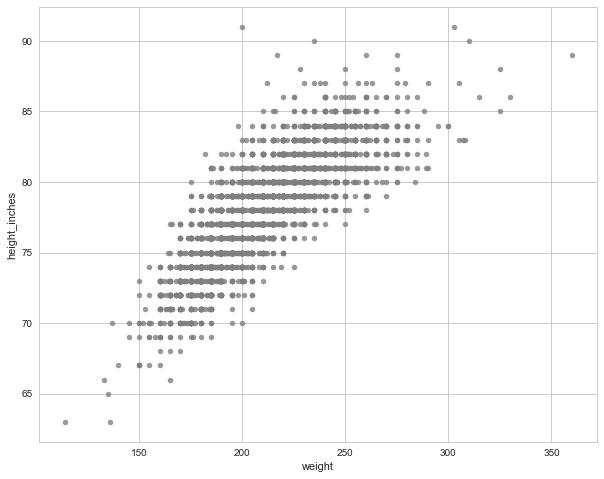

In [249]:
plt.figure(figsize=(10,8))

sns.regplot(x='weight', y='height_inches', data=players_merged_df, color='grey', fit_reg=False, scatter_kws={"s": 30})


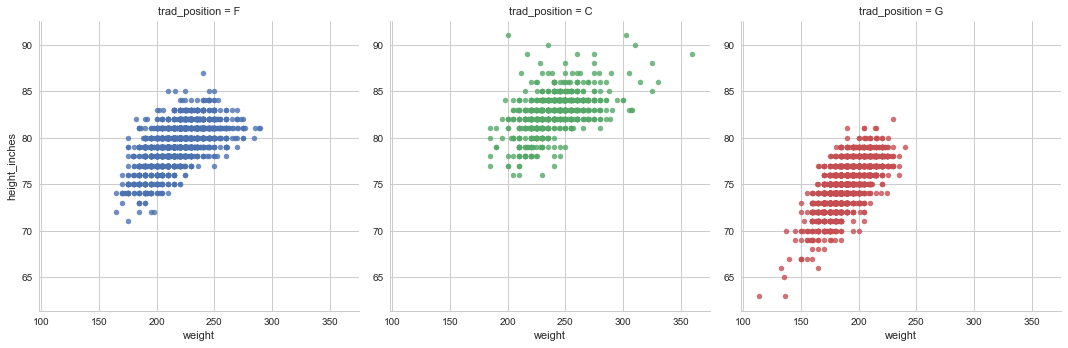

In [239]:
sns.lmplot(x="weight", y="height_inches", data=players_merged_df, 
           col='trad_position', hue='trad_position',
           x_jitter=.1, fit_reg=False, scatter_kws={"s": 30})

In [222]:
players_merged_df.sort_values(by='weight', ascending=False)

,name,active_from,active_to,birth_date,position,ppg,trb,ast,height_inches,weight,shooting_hand,college,hs_name,hs_city,hs_state,url,trad_position
309,Sim Bhullar,2015,2015,1992-12-02,C,0.7,0.3,0.3,89.0,360.0,Right,New Mexico State University,Huntington Prep,Huntington,West Virginia,/players/b/bhullsi01.html,C
1605,Thomas Hamilton,1996,2000,1975-04-03,C,3.2,3.4,0.5,86.0,330.0,Right,University of Pittsburgh,Martin Luther King,Chicago,Illinois,/players/h/hamilth01.html,C
2346,Priest Lauderdale,1997,1998,1973-08-31,C,3.4,1.9,0.4,88.0,325.0,Left,Central State University,Carver,Chicago,Illinois,/players/l/laudepr01.html,C
3034,Shaquille O'Neal,1993,2011,1972-03-06,C,23.7,10.9,2.5,85.0,325.0,Right,Louisiana State University,Cole,San Antonio,Texas,/players/o/onealsh01.html,C
2137,Garth Joseph,2001,2001,1973-08-08,C,0.5,0.5,0.3,86.0,315.0,Right,College of Saint Rose,Saint Mary's,Roseau,Dominica,/players/j/josepga01.html,C
2789,Yao Ming,2003,2011,1980-09-12,C,19.0,9.2,1.6,90.0,310.0,Right,NaN,None,None,None,/players/m/mingya01.html,C
3234,Dexter Pittman,2011,2014,1988-03-02,C,2.3,1.8,0.2,83.0,308.0,Right,University of Texas at Austin,B.F. Terry,Rosenberg,Texas,/players/p/pittmde01.html,C
3176,Nikola Pekovic,2011,2016,1986-01-03,C,12.6,6.7,0.7,83.0,307.0,Right,NaN,None,None,None,/players/p/pekovni01.html,C
3655,Ha Seung-Jin,2005,2006,1985-08-04,C,1.5,1.5,0.1,87.0,305.0,Right,NaN,Samil Commercial,Suwon,Republic of Korea,/players/s/seungha01.html,C
3704,Garret Siler,2011,2011,1986-10-25,C,2.1,1.3,0.1,83.0,305.0,Right,Augusta State University,Richmond Academy,Augusta,Georgia,/players/s/silerga01.html,C
